In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from astropy import units as u
from astropy import constants as const

In [2]:
try:
    from screens.visualization import phasecmap
except ImportError:
    phasecmap = cm.hsv

In [3]:
def phase_intensity_colorbar(fig, ax, phasecmap, ampmax=1.):

    cbar = fig.colorbar(cm.ScalarMappable(), ax=ax, aspect=7.5)
    cbar_pos = fig.axes[-1].get_position()
    cbar.remove()

    nph = 36
    nalpha = 256
    phases = np.linspace(-np.pi, np.pi, nph, endpoint=False) + np.pi/nph
    alphas = np.linspace(0., 1., nalpha, endpoint=False) + 0.5/nalpha
    phasegrid, alphagrid = np.meshgrid(phases, alphas)

    cax = fig.add_axes(cbar_pos)
    cax.imshow(phasegrid, alpha=alphagrid,
               origin='lower', aspect='auto', interpolation='none',
               cmap=phasecmap, extent=[-np.pi, np.pi, 0., ampmax])
    cax.xaxis.tick_top()
    cax.xaxis.set_label_position('top')
    cax.yaxis.tick_right()
    cax.yaxis.set_label_position('right')
    cax.set_xticks([-np.pi, 0., np.pi])
    cax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
    cax.set_xlabel('phase (rad)')
    cax.set_ylabel('normalized intensity')

In [4]:
theta = [-4., -1., 0., 2.] << u.mas

In [5]:
magnification = [-0.1 - 0.1j,
                 0.7 - 0.3j,
                 1.,
                 0.3 + 0.3j]
magnification /= np.sqrt((np.abs(magnification)**2).sum())

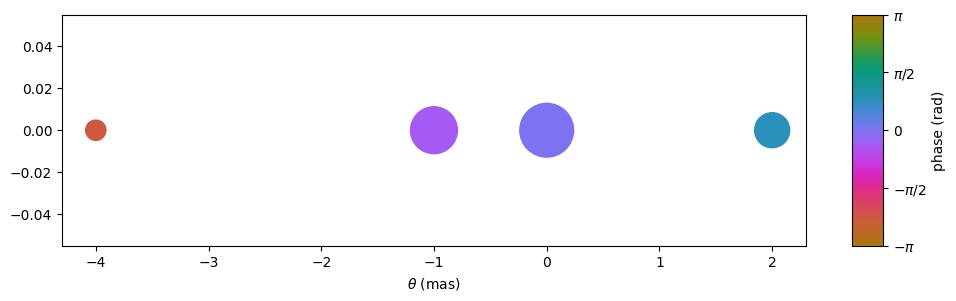

In [6]:
plt.figure(figsize=(12., 3.))
plt.scatter(theta, np.zeros_like(theta),
            s=np.abs(magnification)*2000., c=np.angle(magnification),
            cmap=phasecmap, vmin=-np.pi, vmax=np.pi)

plt.xlabel(rf"$\theta$ ({theta.unit.to_string('latex')})")

cbar = plt.colorbar(aspect=7.5)
cbar.set_label('phase (rad)')
cbar.set_ticks([-np.pi, -np.pi/2., 0., np.pi/2., np.pi])
cbar.set_ticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])

plt.show()

In [7]:
fobs = 316. * u.MHz
delta_f = 2. * u.MHz
delta_t = 90. * u.minute
nf = 200
nt = 180

In [8]:
f = (fobs + np.linspace(-0.5*delta_f, 0.5*delta_f, nf, endpoint=False)
     + 0.5*delta_f/nf)
t = np.linspace(0.*u.minute, delta_t, nt, endpoint=False) + 0.5*delta_t/nt

f, t = np.meshgrid(f, t, sparse=True)

In [9]:
ds_extent = (t[0,0].value  - 0.5*(t[1,0].value - t[0,0].value),
             t[-1,0].value + 0.5*(t[1,0].value - t[0,0].value),
             f[0,0].value  - 0.5*(f[0,1].value - f[0,0].value),
             f[0,-1].value + 0.5*(f[0,1].value - f[0,0].value))

In [10]:
d_eff = 0.5 * u.kpc
mu_eff = 50. * u.mas / u.yr

In [11]:
theta_t = theta[:, np.newaxis, np.newaxis] + mu_eff * t
tau_t = (((d_eff / (2*const.c)) * theta_t**2)
         .to(u.s, equivalencies=u.dimensionless_angles()))

phasor = np.exp(1j * (f * tau_t * u.cycle).to_value(u.rad))
dynwaves = phasor * magnification[:, np.newaxis, np.newaxis]

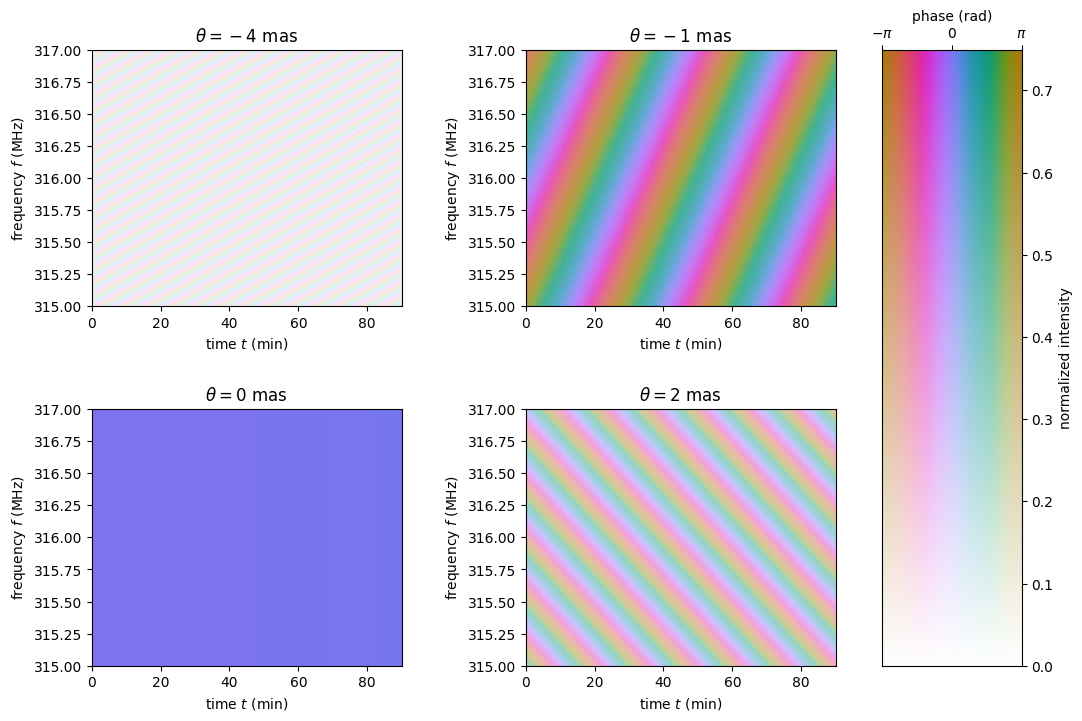

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12., 8.))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for ax, dynwave, th, mag in zip(axes.flat, dynwaves, theta, magnification):
    ax.imshow(np.angle(dynwave).T,
              alpha=np.abs(mag) / np.max(np.abs(magnification)),
              origin='lower', aspect='auto', interpolation='none',
              cmap=phasecmap, extent=ds_extent, vmin=-np.pi, vmax=np.pi)
    ax.set_title(rf"$\theta = {th.value:.0f}$"
                 rf" {theta.unit.to_string('latex')}")
    ax.set_xlabel(rf"time $t$ ({t.unit.to_string('latex')})")
    ax.set_ylabel(rf"frequency $f$ ({f.unit.to_string('latex')})")

phase_intensity_colorbar(fig, axes, phasecmap,
                         ampmax=np.max(np.abs(magnification)))

plt.show()

In [13]:
dynwave = dynwaves.sum(axis=0)

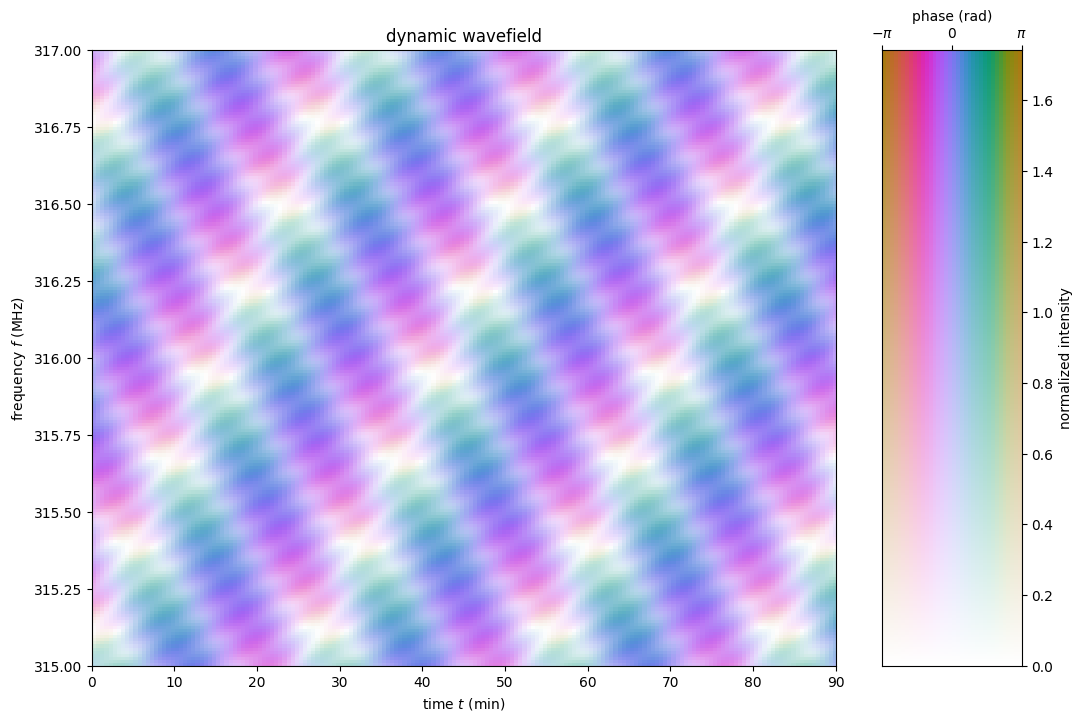

In [14]:
fig = plt.figure(figsize=(12., 8.))
ax = plt.subplot(111)
plt.imshow(np.angle(dynwave).T,
           alpha=(np.abs(dynwave).T / np.max(np.abs(dynwave))),
           origin='lower', aspect='auto', interpolation='none',
           cmap=phasecmap, extent=ds_extent, vmin=-np.pi, vmax=np.pi)
plt.title('dynamic wavefield')
plt.xlabel(rf"time $t$ ({t.unit.to_string('latex')})")
plt.ylabel(rf"frequency $f$ ({f.unit.to_string('latex')})")

phase_intensity_colorbar(fig, ax, phasecmap,
                         ampmax=np.max(np.abs(dynwave)))

plt.show()

In [15]:
dynspec = np.abs(dynwave)**2

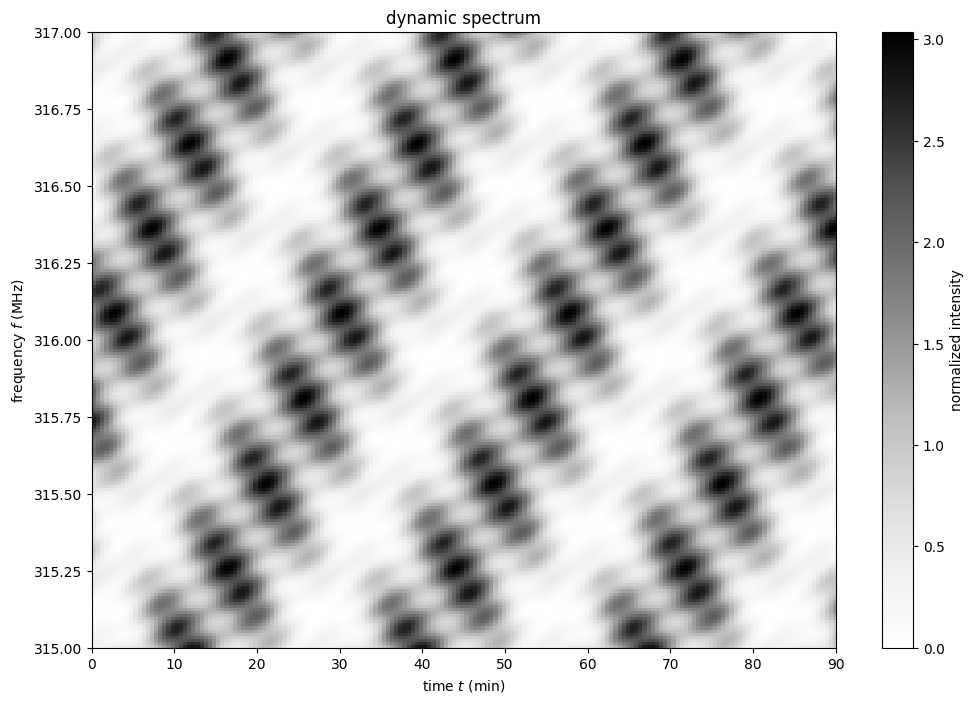

In [16]:
plt.figure(figsize=(12., 8.))
plt.imshow(dynspec.T,
           origin='lower', aspect='auto', interpolation='none',
           cmap='Greys', extent=ds_extent, vmin=0.)
plt.title('dynamic spectrum')
plt.xlabel(rf"time $t$ ({t.unit.to_string('latex')})")
plt.ylabel(rf"frequency $f$ ({f.unit.to_string('latex')})")

cbar = plt.colorbar()
cbar.set_label('normalized intensity')

plt.show()

In [17]:
conjspec = np.fft.fft2(dynspec)
conjspec /= conjspec[0, 0]
conjspec = np.fft.fftshift(conjspec)

In [18]:
tau = np.fft.fftfreq(dynspec.shape[1], f[0,1] - f[0,0]).to(u.us)
fd = np.fft.fftfreq(dynspec.shape[0], t[1,0] - t[0,0]).to(u.mHz)

tau = np.fft.fftshift(tau)
fd = np.fft.fftshift(fd)

In [19]:
secspec = np.abs(conjspec)**2

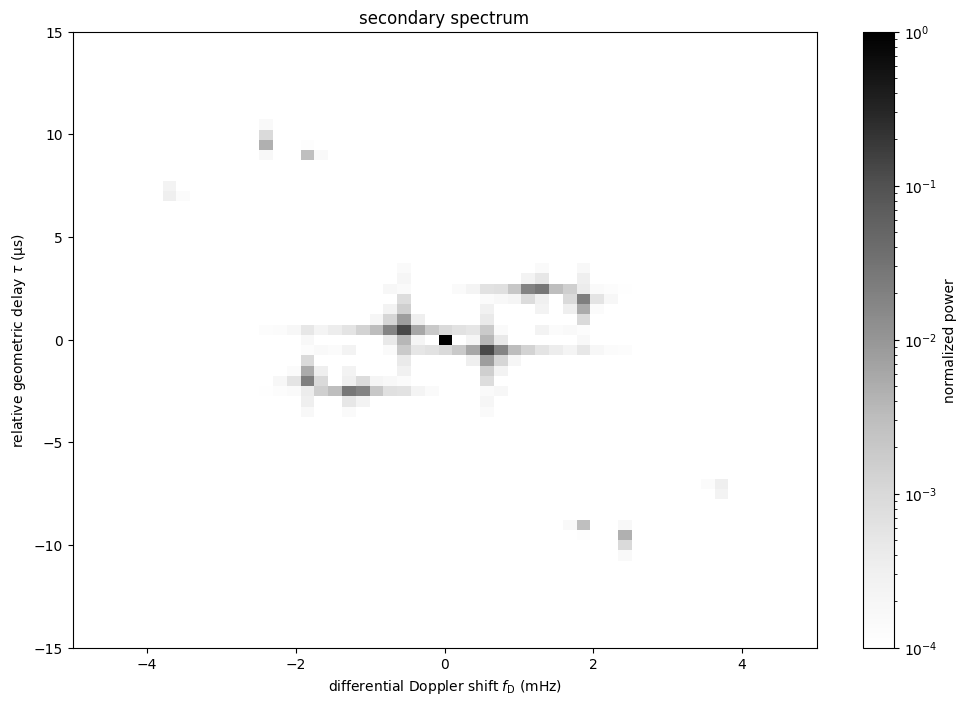

In [20]:
ss_extent = (fd[0].value  - 0.5*(fd[1].value - fd[0].value),
             fd[-1].value + 0.5*(fd[1].value - fd[0].value),
             tau[0].value  - 0.5*(tau[1].value - tau[0].value),
             tau[-1].value + 0.5*(tau[1].value - tau[0].value))

plt.figure(figsize=(12., 8.))
plt.imshow(secspec.T,
           origin='lower', aspect='auto', interpolation='none',
           cmap='Greys', extent=ss_extent,
           norm=LogNorm(vmin=1.e-4, vmax=1.))
plt.title('secondary spectrum')
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})")
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})")
plt.xlim(-5., 5.)
plt.ylim(-15., 15.)

cbar = plt.colorbar()
cbar.set_label('normalized power')

plt.show()